# AI Travel Agent (ReAct Agent Version)

This notebook demonstrates how to use a LangChain ReAct agent to plan a trip, using modular tools for weather, hotels, attractions, currency, and more. The agent dynamically decides which tools to use based on your prompt.

## Install and Import Dependencies

In [43]:
import os
from dotenv import load_dotenv
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
from langchain.chat_models import ChatOpenAI
from langchain_google_community import GooglePlacesTool
from langchain_community.utilities import SerpAPIWrapper
from forex_python.converter import CurrencyRates
import requests
from langgraph.graph import StateGraph, END, START
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, Image

## Load API Keys

In [44]:
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
EXCHANGE_RATE_API_KEY = os.getenv('EXCHANGE_RATE_API_KEY')
GPLACES_API_KEY = os.getenv('GPLACES_API_KEY')
SERPAPI_KEY = os.getenv('SERPAPI_KEY')

## Define Service Classes

In [45]:
class WeatherService:
    def __init__(self, api_key):
        self.api_key = api_key

    def get_current_weather(self, city):
        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {"q": city, "appid": self.api_key, "units": "metric"}
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            return {
                "city": city,
                "temperature": data["main"]["temp"],
                "description": data["weather"][0]["description"],
                "humidity": data["main"]["humidity"],
                "wind_speed": data["wind"]["speed"]
            }
        else:
            return {"error": f"Failed to get weather for {city}: {response.text}"}

    def get_forecast(self, city, days=3):
        url = "https://api.openweathermap.org/data/2.5/forecast"
        params = {"q": city, "appid": self.api_key, "units": "metric"}
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            forecasts = []
            for entry in data["list"]:
                forecast = {
                    "datetime": entry["dt_txt"],
                    "temperature": entry["main"]["temp"],
                    "description": entry["weather"][0]["description"]
                }
                forecasts.append(forecast)
            return forecasts[:days*8]
        else:
            return {"error": f"Failed to get forecast for {city}: {response.text}"}

class CurrencyService:
    def __init__(self, api_key):
        self.api_key = api_key

    def get_exchange_rate(self, from_currency, to_currency):
        url = f"https://v6.exchangerate-api.com/v6/{self.api_key}/latest/{from_currency}"
        response = requests.get(url)
        data = response.json()
        if data["result"] == "success":
            return data["conversion_rates"].get(to_currency)
        return None

    def convert_currency(self, amount, from_currency, to_currency):
        rate = self.get_exchange_rate(from_currency, to_currency)
        if rate:
            return amount * rate
        return None
class ItineraryService:
    def create_day_plan(self, city, attractions, weather):
        return {
            "city": city,
            "attractions": attractions,
            "weather": weather
        }

    def create_full_itinerary(self, days, day_plans):
        itinerary = []
        for i in range(int(days)):
            if i < len(day_plans):
                itinerary.append(day_plans[i])
            else:
                itinerary.append({"day": i+1, "note": "No plan available"})
        return itinerary

## Initialize Services and Tool Wrappers

In [46]:
weather_service = WeatherService(OPENWEATHER_API_KEY)
currency_service = CurrencyService(EXCHANGE_RATE_API_KEY)
places_tool = GooglePlacesTool(gplaces_api_key=GPLACES_API_KEY)
serpapi_wrapper = SerpAPIWrapper(serpapi_api_key=SERPAPI_KEY)

## Define Tools

In [47]:
@tool
def get_current_weather(city: str):
    """Get current weather for a city."""
    return weather_service.get_current_weather(city)

@tool
def get_forecast(city: str, days: int = 3):
    """Get weather forecast for a city."""
    return weather_service.get_forecast(city, days)

@tool
def search_attractions(city: str):
    """Search for top attractions in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"tourist attractions in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"top attractions in {city}")

@tool
def search_hotels(city: str, budget: str = "mid-range"):
    """Search for hotels in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"{budget} hotels in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"{budget} hotels in {city}")

@tool
def get_exchange_rate(from_currency: str, to_currency: str):
    """Get exchange rate between two currencies."""
    return currency_service.get_exchange_rate(from_currency, to_currency)

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str):
    """Convert amount from one currency to another."""
    return currency_service.convert_currency(amount, from_currency, to_currency)

## Initialize the React Agent

In [48]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo-16k",
    openai_api_key=OPENAI_API_KEY,
    temperature=0
)

tools = [
    get_current_weather,
    get_forecast,
    search_attractions,
    search_hotels,
    get_exchange_rate,
    convert_currency
]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.OPENAI_FUNCTIONS,  # Use this for OpenAI tool-calling agent
    verbose=True
)

## Prompt - Ask the agent to Plan a Trip

In [49]:
prompt = """
I want to visit Rome for 4 days with a focus on history, art, and food.
My budget is 800 EUR. Please provide:
- Weather forecast
- Must-see historical sites and museums
- Best local restaurants for Italian cuisine
- Hotel options near major attractions
- A day-by-day itinerary
- Estimated daily and total costs in EUR
- Tips for getting around the city
- Present the summary in a clear, organized format.
"""
response = agent.invoke({"input": prompt})
print(response)



> Entering new AgentExecutor chain...

Invoking: `get_forecast` with `{'city': 'Rome', 'days': 4}`


[{'datetime': '2025-06-20 18:00:00', 'temperature': 29.77, 'description': 'clear sky'}, {'datetime': '2025-06-20 21:00:00', 'temperature': 29.87, 'description': 'clear sky'}, {'datetime': '2025-06-21 00:00:00', 'temperature': 27.16, 'description': 'clear sky'}, {'datetime': '2025-06-21 03:00:00', 'temperature': 21.93, 'description': 'clear sky'}, {'datetime': '2025-06-21 06:00:00', 'temperature': 20.48, 'description': 'clear sky'}, {'datetime': '2025-06-21 09:00:00', 'temperature': 19.37, 'description': 'clear sky'}, {'datetime': '2025-06-21 12:00:00', 'temperature': 21.62, 'description': 'clear sky'}, {'datetime': '2025-06-21 15:00:00', 'temperature': 29.86, 'description': 'clear sky'}, {'datetime': '2025-06-21 18:00:00', 'temperature': 33.72, 'description': 'clear sky'}, {'datetime': '2025-06-21 21:00:00', 'temperature': 33.72, 'description': 'clear sky'}, {'datetime': '2025-06-22 0

## Build Workflow 

In [50]:


# --- Nodes ---
def weather_node(state):
    city = state.get("city")
    days = state.get("days", 3)
    weather = weather_service.get_forecast(city, days)
    state["weather"] = weather
    return state

def attractions_node(state):
    city = state.get("city")
    try:
        result = places_tool.run(f"tourist attractions in {city}")
        if result and len(result) > 0:
            state["attractions"] = result
            state["use_fallback"] = False
        else:
             result = serpapi_wrapper.run(f"top attractions in {city}")
             state["attractions"] = result
    except Exception:
        raise Exception("Empty")
        state["use_fallback"] = True
    return state
            
def hotels_node(state):
    city = state.get("city")
    budget = state.get("budget", "mid-range")
    try:
        result = places_tool.run(f"{budget} hotels in {city}")
        if result and len(result) > 0:
            state["hotels"] = result
            state["use_hotels_fallback"] = False
        else:
            raise Exception("No hotels found")
    except Exception:
        fallback = serpapi_wrapper.run(f"{budget} hotels in {city}")
        state["hotels"] = fallback
        state["use_hotels_fallback"] = True
    return state

def itinerary_node(state):
    city = state.get("city")
    days = state.get("days", 3)
    attractions = state.get("attractions")
    weather = state.get("weather")
    day_plans = [
        itinerary_service.create_day_plan(city, attractions, weather)
        for _ in range(days)
    ]
    itinerary = itinerary_service.create_full_itinerary(days, day_plans)
    state["itinerary"] = itinerary
    return state

def summary_node(state):
    summary = {
        "city": state.get("city"),
        "days": state.get("days"),
        "weather": state.get("weather"),
        "attractions": state.get("attractions"),
        "hotels": state.get("hotels"),
        "itinerary": state.get("itinerary"),
        "total_cost": state.get("total_cost"),
        "daily_budget": state.get("daily_budget"),
        "attractions_fallback_used": state.get("use_attractions_fallback", False),
        "hotels_fallback_used": state.get("use_hotels_fallback", False)
    }
    state["summary"] = summary
    return state

# --- Graph Build ---
graph = StateGraph(dict)

# Add nodes
graph.add_node("weather", weather_node)
graph.add_node("attractions", attractions_node)

graph.add_node("hotels", hotels_node)
graph.add_node("itinerary", itinerary_node)
graph.add_node("summary", summary_node)

# Add edges
graph.add_edge(START, "weather")
graph.add_edge("weather", "attractions")

graph.add_edge("attractions", "hotels")
graph.add_edge("hotels", "itinerary")
graph.add_edge("itinerary", "summary")
graph.add_edge("summary", END)

# Compile
workflow = graph.compile()


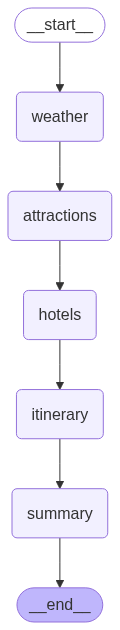

In [51]:
from IPython.display import display, Image
display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

## **Summary**

In [52]:
initial_state = {"city": "Rome", "days": 3, "budget": "mid-range"}
result = workflow.invoke(initial_state)
print("=== Trip Summary ===")
print(result.get("summary"))

=== Trip Summary ===
{'city': 'Rome', 'days': 3, 'weather': [{'datetime': '2025-06-20 18:00:00', 'temperature': 29.77, 'description': 'clear sky'}, {'datetime': '2025-06-20 21:00:00', 'temperature': 29.87, 'description': 'clear sky'}, {'datetime': '2025-06-21 00:00:00', 'temperature': 27.16, 'description': 'clear sky'}, {'datetime': '2025-06-21 03:00:00', 'temperature': 21.93, 'description': 'clear sky'}, {'datetime': '2025-06-21 06:00:00', 'temperature': 20.48, 'description': 'clear sky'}, {'datetime': '2025-06-21 09:00:00', 'temperature': 19.37, 'description': 'clear sky'}, {'datetime': '2025-06-21 12:00:00', 'temperature': 21.62, 'description': 'clear sky'}, {'datetime': '2025-06-21 15:00:00', 'temperature': 29.86, 'description': 'clear sky'}, {'datetime': '2025-06-21 18:00:00', 'temperature': 33.72, 'description': 'clear sky'}, {'datetime': '2025-06-21 21:00:00', 'temperature': 33.72, 'description': 'clear sky'}, {'datetime': '2025-06-22 00:00:00', 'temperature': 28.54, 'descriptio